**Create Hexbins of a given city and export population,tree canopy, temperature, cooling etc maps. **

In [1]:
# Import packages
import geopandas as gpd , os , geemap , ee 
import rasterio
from rasterio.mask import mask
import osmnx as ox
from shapely.geometry import box
from rasterio.plot import show
import pylab as plt
from geopandas.tools import sjoin
import contextily as cx
from h3 import h3
import h3pandas
from rasterstats import zonal_stats
import pandas as pd
import numpy as np
from rasterio.crs import CRS
import matplotlib.colors as colors
import warnings
warnings.filterwarnings("ignore")


In [2]:
def set_paths(base_dir):
    data = os.path.join(base_dir, 'data') 
    output = os.path.join(base_dir, 'output') 
    shapefiles = os.path.join(output, 'shapefiles') 
    maps = os.path.join(output, 'maps') 
    rasters = os.path.join(output, 'rasters') 
    
    dirs_list= [ shapefiles , maps , rasters]
    for dir in dirs_list:
        if not os.path.exists(dir):
            os.mkdir(dir)

    return shapefiles , maps , rasters

base_dir = 'C:/Users/Aziz/Dropbox/CRP/UHI'
shapefiles , maps , rasters= set_paths(base_dir)

Initialize ee and import shapefile and select city

In [3]:
ee.Initialize()
run_uh_analysis=True
WGS84=4326
EPSG_str= 'EPSG:4326'
city= "Phnom Penh"
gdf_WA = gpd.read_file(f'{shapefiles}/khm_admbnda_adm1_gov_20181004.shp').to_crs(WGS84)
gdf_WA=gdf_WA[gdf_WA["ADM1_EN"] == city]

In [4]:

def clip_and_export_raster(input_gpdf, raster , out_raster, zonal_stat_var):
    Vector=input_gpdf
    with rasterio.open(raster) as src:
        Vector=Vector.to_crs(src.crs)
        # print(f'Gdf srs: {Vector.crs}')
        out_image, out_transform=mask(src,Vector.geometry,crop=True)
        out_meta=src.meta.copy() # copy the metadata of the source DEM
        
    out_meta.update({
        "driver":"Gtiff",
        "height":out_image.shape[1], # height starts with shape[1]
        "width":out_image.shape[2], # width starts with shape[2]
        "transform":out_transform
    })
                
    with rasterio.open(out_raster,'w',**out_meta) as dst:
        dst.write(out_image)

    # add zonal stats to the hexbin gpd dataframe and replace nans with 0 
    hexbins_projected[zonal_stat_var] = zonal_stats(hexbins_projected, out_raster ,stats='mean')
    hexbins_projected[zonal_stat_var] = [item['mean'] for item in hexbins_projected[zonal_stat_var]]
    hexbins_projected[zonal_stat_var].fillna(0,inplace=True)
    max=int(hexbins_projected.loc[hexbins_projected[zonal_stat_var].idxmax()][zonal_stat_var])
    
    return hexbins_projected , max

In [5]:
def create_hexbins_and_geom_features(gdf_WA, hexbin_res, WGS84):
    poly = gdf_WA.geometry.unary_union
    gdf_boundary = gpd.GeoDataFrame(geometry=[poly],crs=gdf_WA.crs)
    # gdf_h3 = gdf_boundary.h3.polyfill(9,explode=True)
    gdf_h3 = gdf_boundary.h3.polyfill(hexbin_res,explode=True)
    gdf_h3 = gdf_h3.set_index('h3_polyfill').h3.h3_to_geo_boundary()
    output_shapefile= f'{shapefiles}/h3_grid.shp'
    gdf_h3.to_file(output_shapefile)
    hexbins_projected = gpd.read_file(output_shapefile).to_crs(WGS84)

    geom = gdf_boundary['geometry']
    jsonDict = eval(geom.to_json())
    for index, row in gdf_boundary.iterrows(): 
        polygon_list= []
        for x in jsonDict['features'][index]['geometry']['coordinates']:
            polygon_list.append(x)
            region = ee.Geometry.Polygon(polygon_list)
            fc_filtered = ee.FeatureCollection(region)
            
    gdf_h3.plot()

    return fc_filtered  , region , hexbins_projected

In [6]:
# Change colormap by truncating
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [7]:
def zonal_stats_tree_cover(ee , EPSG_str):

    tree_cover=ee.ImageCollection("projects/sat-io/open-datasets/GFCC30TC") \
        .limit(1, 'system:time_start', False).first().clip(fc_filtered)

    tif = os.path.join(rasters, 'tree_cover_projected.tif')
    geemap.ee_export_image(
        tree_cover, filename=tif,  
        crs=EPSG_str,
        # crs_transform=crs_transform,
        scale=30, region=region, file_per_band=False
    )

    # add zonal stats to the hexbin gpd dataframe and replace nans with 0 
    hexbins_projected['tree_cover_sum'] = zonal_stats(hexbins_projected, tif ,stats='sum')
    hexbins_projected['tree_cover_sum'] = [item['sum'] for item in hexbins_projected['tree_cover_sum']]
    hexbins_projected['tree_cover_sum'].fillna(0,inplace=True)
    max=int(hexbins_projected.loc[hexbins_projected['tree_cover_sum'].idxmax()]['tree_cover_sum'])
    
    return hexbins_projected , max

In [8]:
def clipToCol(image):
  """clip gee collection
  args:
      image: Image collection
  returns:
    ee-collection: Clipped image collection
   
   """
  return image.clip(fc_filtered)

In [9]:
def export_map(map_dir, hexagons, crs,cmap,  visualize_column, title):
    ax = hexagons.to_crs(crs).plot(figsize=(12, 12) ,vmin=0,  vmax=int(max/4) , \
                                   alpha=0.6, column=visualize_column, \
                                    cmap=cmap,legend=True, \
                                        legend_kwds={'shrink': 0.77, 'orientation': 'vertical', \
                                                      'location': 'right', 'label': f'{title}', \
                                                        'pad':0.009})

    gdf_WA.to_crs(crs).plot(ax=ax,facecolor='none',edgecolor='k',alpha=0.2)
    cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite,  crs=crs) 
    cx.add_basemap(ax, source=cx.providers.Stamen.TonerLabels,   crs=crs) # zoom=13
    plt.title(f'{title}',fontsize=20)
    plt.xticks([])
    plt.yticks([])
        
    ax.figure.set_size_inches(12, 12)
    plt.tight_layout()
    ax.figure.savefig(f"{map_dir}/{city}_{visualize_column}_truncated_cmap_max_div_4.png")


In [10]:
def export_map_uh(map_dir, hexagons, crs,cmap,  visualize_column, title):
    ax = hexagons.to_crs(crs).plot(figsize=(12, 12) , \
                                   alpha=0.6, column=visualize_column, \
                                    cmap=cmap,legend=True, \
                                        legend_kwds={'shrink': 0.77, 'orientation': 'vertical', \
                                                      'location': 'right', 'label': f'{title}', \
                                                        'pad':0.009})

    gdf_WA.to_crs(crs).plot(ax=ax,facecolor='none',edgecolor='k',alpha=0.2)
    cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite,  crs=crs) 
    cx.add_basemap(ax, source=cx.providers.Stamen.TonerLabels,   crs=crs) # zoom=13
    plt.title(f'{title}',fontsize=20)
    plt.xticks([])
    plt.yticks([])
        
    ax.figure.set_size_inches(12, 12)
    plt.tight_layout()
    ax.figure.savefig(f"{map_dir}/{city}_{visualize_column}_truncated_cmap_max_div_4.png")


In [11]:
def zonal_stats_tree_cover_esa_vito(ee , EPSG_str):

    tree_cover=ee.ImageCollection("ESA/WorldCover/v100") \
        .limit(1, 'system:time_start', False).first().clip(fc_filtered).eq(10) #trees only
        # .limit(1, 'system:time_start', False).select(10).first().clip(fc_filtered) #trees only

    tif = os.path.join(rasters, 'tree_cover_projected.tif')
    geemap.ee_export_image(
        tree_cover, filename=tif,  
        crs=EPSG_str,
        # crs_transform=crs_transform,
        scale=10, region=region, file_per_band=False
    )

    # add zonal stats to the hexbin gpd dataframe and replace nans with 0 
    hexbins_projected['tree_cover_sum_esa'] = zonal_stats(hexbins_projected, tif ,stats='sum')
    hexbins_projected['tree_cover_sum_esa'] = [item['sum'] for item in hexbins_projected['tree_cover_sum_esa']]
    hexbins_projected['tree_cover_sum_esa'].fillna(0,inplace=True)
    max=int(hexbins_projected.loc[hexbins_projected['tree_cover_sum_esa'].idxmax()]['tree_cover_sum_esa'])
    
    return hexbins_projected , max


In [12]:
def zonal_stats_pop_density(ee , EPSG_str):
    #  Define WorldPop & clip using function 
    pop_density = ee.ImageCollection("WorldPop/GP/100m/pop").map(clipToCol). \
                    filterDate('2020').select('population').mosaic()

    tif = os.path.join(rasters, 'pop_density_projected.tif')
    geemap.ee_export_image( pop_density, 
                           filename=tif,  
                           crs=EPSG_str,
                           # crs_transform=crs_transform,
                           scale=100, 
                           region=region, 
                           file_per_band=False
                           )

    # add zonal stats to the hexbin gpd dataframe and replace nans with 0 
    hexbins_projected['pop_density_sum'] = zonal_stats(hexbins_projected, tif ,stats='sum')
    hexbins_projected['pop_density_sum'] = [item['sum'] for item in hexbins_projected['pop_density_sum']]
    hexbins_projected['pop_density_sum'].fillna(0,inplace=True)
    max=int(hexbins_projected.loc[hexbins_projected['pop_density_sum'].idxmax()]['pop_density_sum'])
    
    return hexbins_projected , max

In [13]:
def calculate_trees_to_people_ratio(hexbins_projected , tree_cover_type):
    hexbins_projected[f'{tree_cover_type}_div_people']= hexbins_projected[[tree_cover_type]].div(hexbins_projected.pop_density_sum, axis=0) #.astype(int)
    hexbins_projected[f'{tree_cover_type}_div_people']= hexbins_projected[f'{tree_cover_type}_div_people'].apply("int64")
    max=int(hexbins_projected.loc[hexbins_projected[f'{tree_cover_type}_div_people'].idxmax()][f'{tree_cover_type}_div_people'])
    return hexbins_projected , max


In [14]:
def get_uh_raster_dirs(input_raster_dir):
    raster_dirs=  [x[1] for x in os.walk(input_raster_dir)] # ['Present', 'SSP119' , 'SSP370']
    raster_dirs = [x for x in raster_dirs if len(x)>0]
    raster_dirs = list(np.concatenate(raster_dirs))
    return raster_dirs

In [15]:
def clip_and_reproject_rasters():
    for subdir in raster_dirs:
        extension = '.tif'
        for root, dirs_list, files_list in os.walk( os.path.join(input_raster_dir, subdir)):
            for file_name in files_list:
                if os.path.splitext(file_name)[-1] == extension:
                    file_name_path = os.path.join(root, file_name)
                    file_name = os.path.splitext(file_name)[0]
                    file_name = ' '.join(file_name.split("_")[:-2])
                    # print(file_name,  file_name_path)
                    rst = file_name_path 
                    #clip and export rasters 
                    out_rst = f'{rasters}/{file_name} {subdir}_clipped.tif'
                    hexbins_projected , max= clip_and_export_raster(input_gpdf=gdf_WA, raster=rst , out_raster=out_rst, zonal_stat_var=file_name)
                    cmap = plt.get_cmap('RdYlGn', 10)
                    cmap = truncate_colormap(cmap, 0.1, 1)
                    export_tree_cover= export_map_uh(map_dir= maps, hexagons=hexbins_projected, crs=WGS84, cmap=cmap , visualize_column=file_name, title=file_name)


C:\Users\Aziz\AppData\Local\Temp\ipykernel_11876\3035060070.py:8: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_h3.to_file(output_shapefile)


Generating URL ...
Please wait ...
Data downloaded to C:\Users\Aziz\Dropbox\CRP\UHI\output\rasters\tree_cover_projected.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\Aziz\Dropbox\CRP\UHI\output\rasters\tree_cover_projected.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\Aziz\Dropbox\CRP\UHI\output\rasters\pop_density_projected.tif


c:\Users\Aziz\anaconda3\envs\uh\lib\site-packages\rasterstats\io.py:328: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(
c:\Users\Aziz\anaconda3\envs\uh\lib\site-packages\pandas\core\series.py:917: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)
c:\Users\Aziz\anaconda3\envs\uh\lib\site-packages\pandas\core\series.py:917: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)


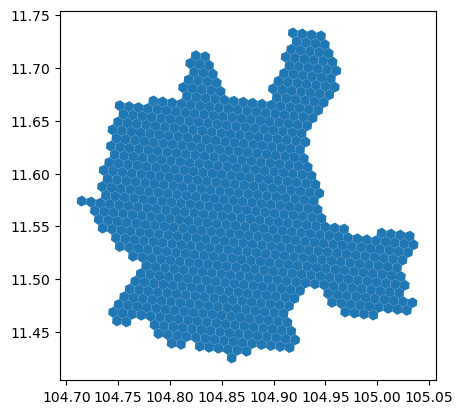

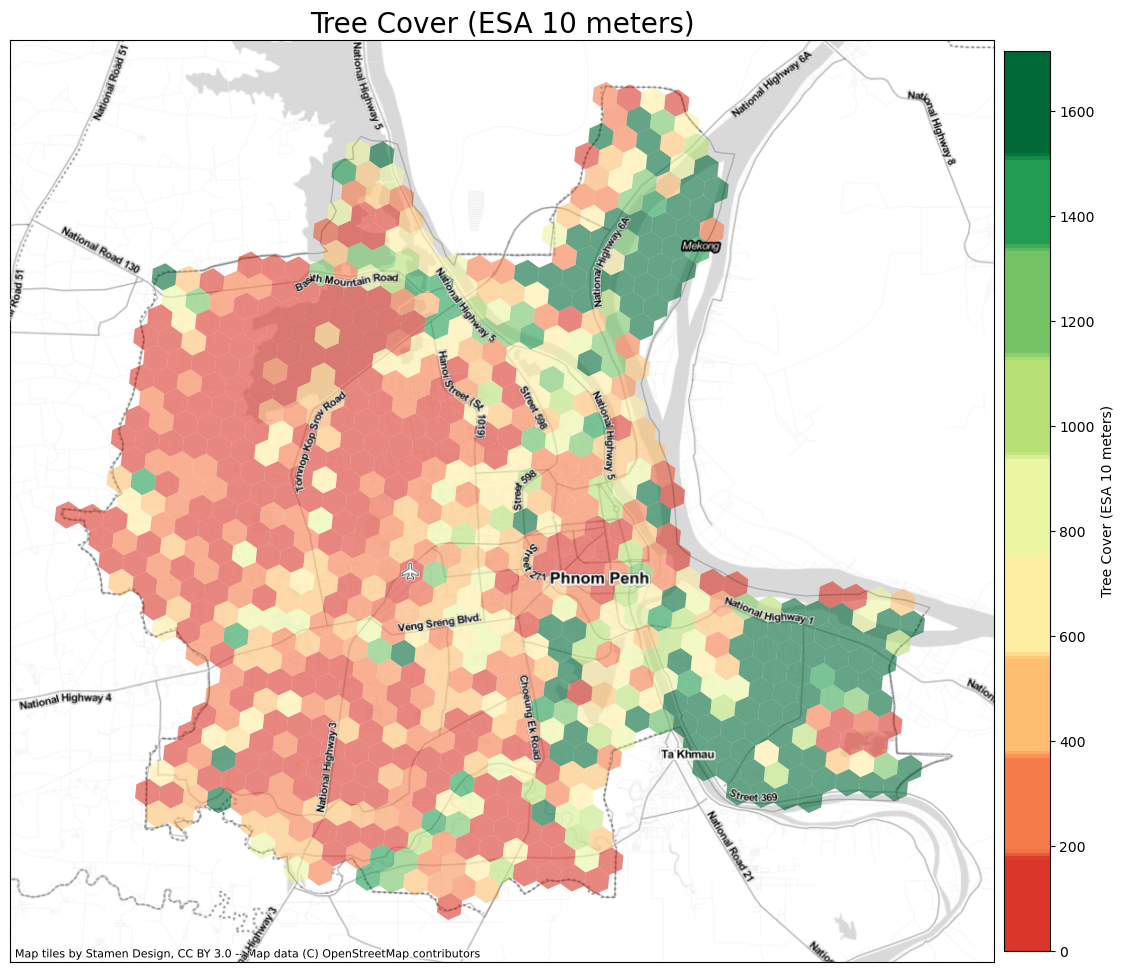

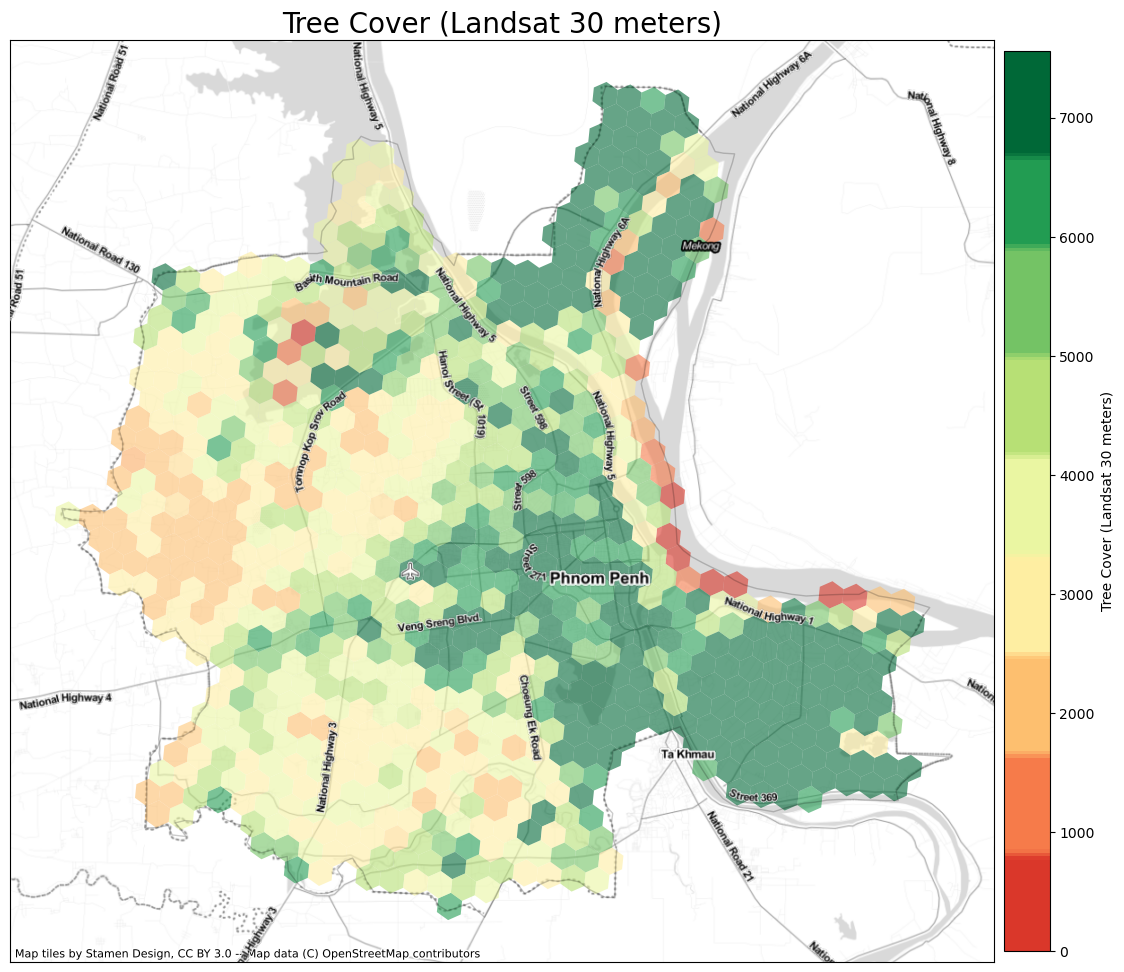

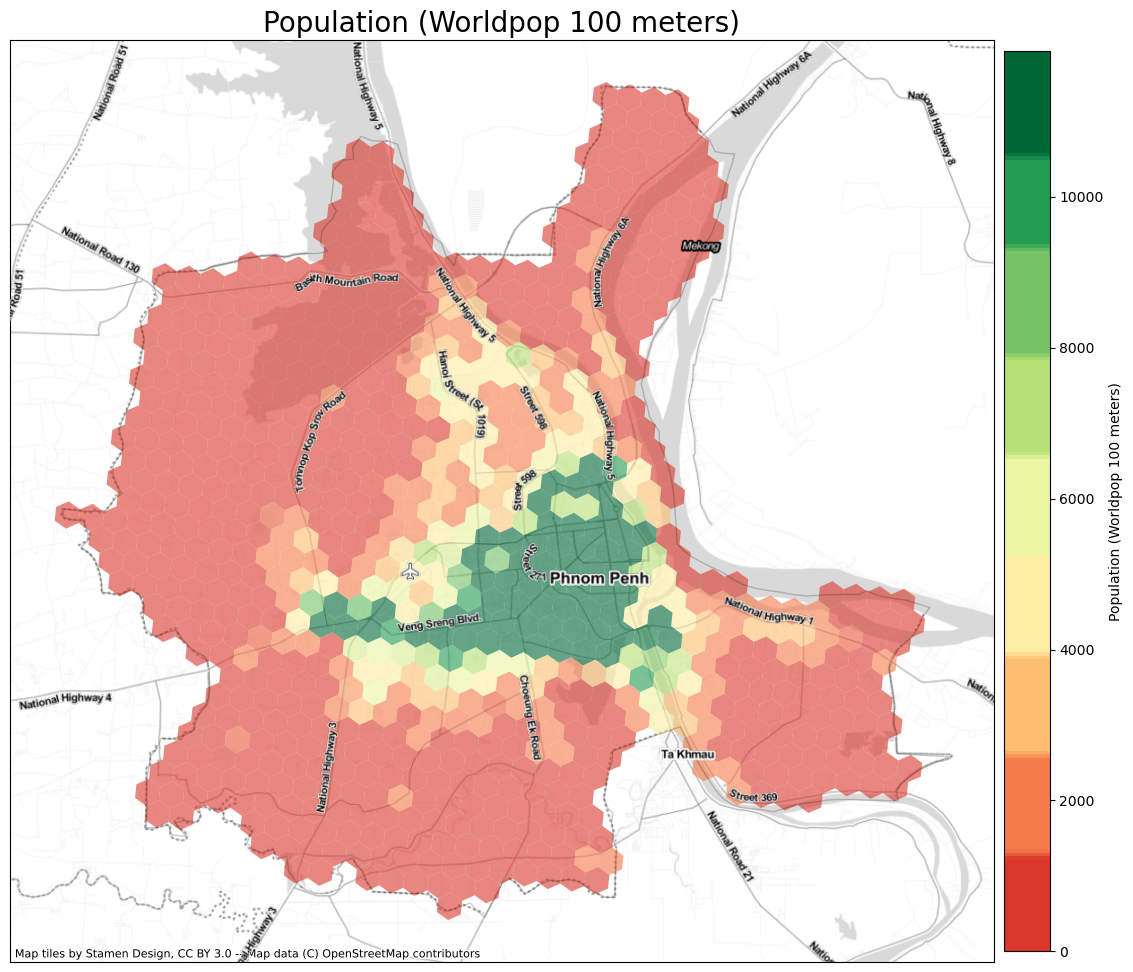

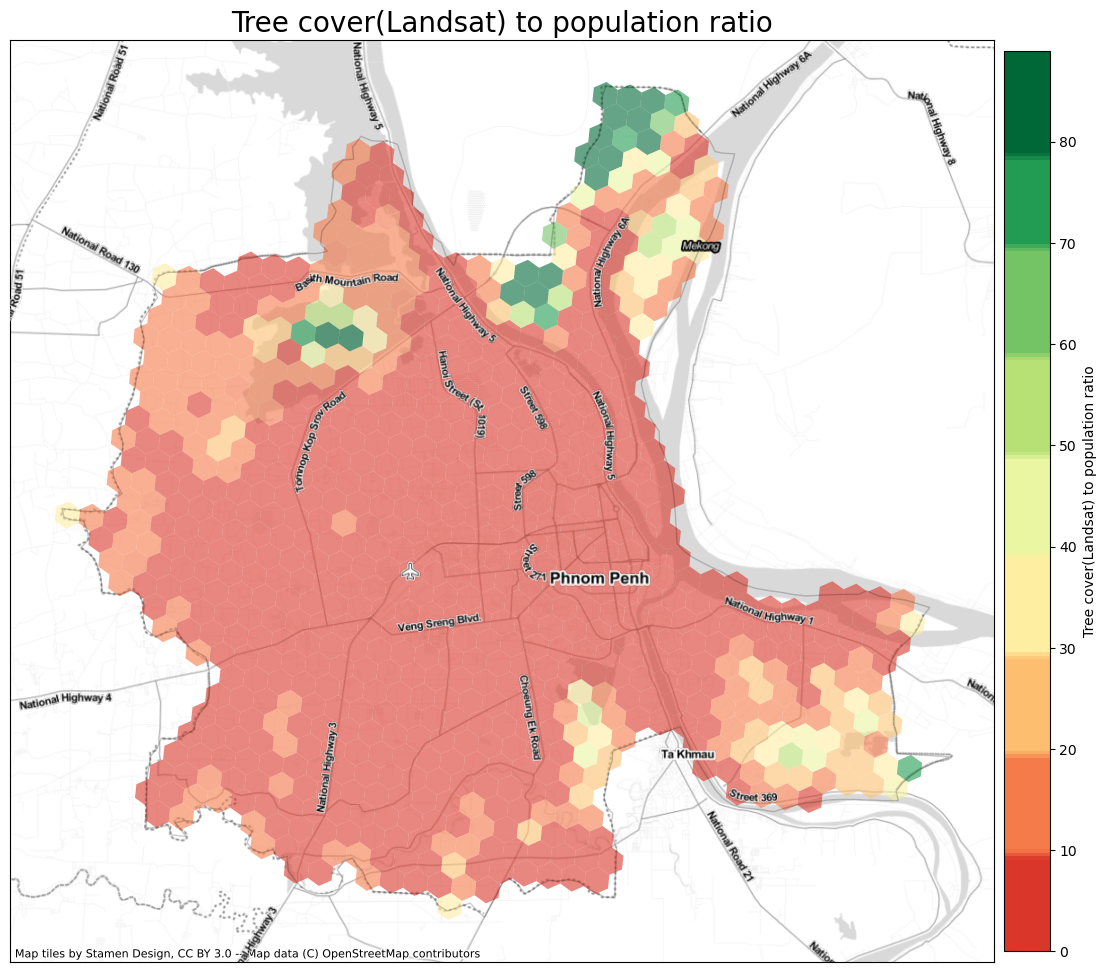

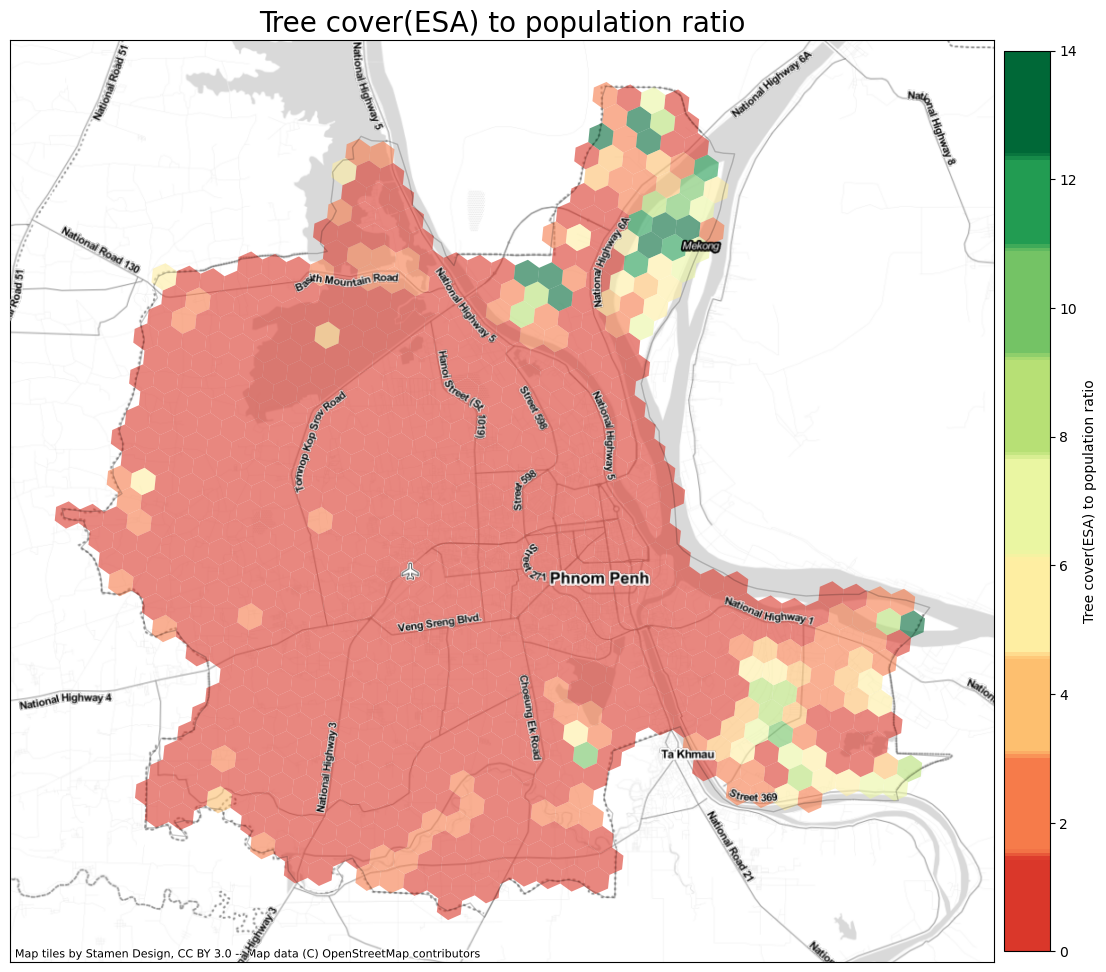

In [16]:
if __name__ == "__main__":
    fc_filtered  , region , hexbins_projected= create_hexbins_and_geom_features(gdf_WA, hexbin_res=8, WGS84=WGS84)
    hexbins_projected , max=  zonal_stats_tree_cover_esa_vito(ee , EPSG_str)
    cmap = plt.get_cmap('RdYlGn', 10)
    cmap = truncate_colormap(cmap, 0.1, 1)
    export_tree_cover= export_map(map_dir= maps, hexagons=hexbins_projected, crs=WGS84, cmap=cmap , visualize_column='tree_cover_sum_esa', title="Tree Cover (ESA 10 meters)")
    hexbins_projected , max= zonal_stats_tree_cover(ee , EPSG_str)
    export_tree_cover= export_map(map_dir= maps, hexagons=hexbins_projected, crs=WGS84, cmap=cmap , visualize_column='tree_cover_sum', title="Tree Cover (Landsat 30 meters)")
    hexbins_projected , max= zonal_stats_pop_density(ee , EPSG_str)
    export_pop_density= export_map(map_dir= maps, hexagons=hexbins_projected, crs=WGS84, cmap=cmap , visualize_column='pop_density_sum' , title="Population (Worldpop 100 meters)")
    tree_cover_type= 'tree_cover_sum'
    hexbins_projected , max=calculate_trees_to_people_ratio(hexbins_projected , tree_cover_type=tree_cover_type)
    tree_cover_type= f'{tree_cover_type}_div_people'
    export_tree_cover= export_map(map_dir= maps, hexagons=hexbins_projected, crs=WGS84, cmap=cmap , visualize_column=tree_cover_type, title="Tree cover(Landsat) to population ratio")
    tree_cover_type= 'tree_cover_sum_esa'
    hexbins_projected , max=calculate_trees_to_people_ratio(hexbins_projected , tree_cover_type=tree_cover_type)
    tree_cover_type= f'{tree_cover_type}_div_people'
    export_tree_cover= export_map(map_dir= maps, hexagons=hexbins_projected, crs=WGS84, cmap=cmap , visualize_column=tree_cover_type, title="Tree cover(ESA) to population ratio")



In [17]:
if run_uh_analysis:
    input_raster_dir = f'{base_dir}/data/Phnom Penh/Geotiffs'
    raster_dirs= get_uh_raster_dirs(input_raster_dir)
    clip_and_reproject_rasters= clip_and_reproject_rasters()


KeyError: 'sum'